## Introdução ##

O acompanhamento nutricional de lactentes e pré-lactentes é um interesse nacional, pois pode revelar verdades sociais e econômicas, além de nutricionais, a respeito de cidades e Estados no Brasil. Também diz respeito a saúde das crianças e das gestantes do Brasil. 

No entanto, esse trabalho é dificultado pelo formato como esses dados são apresentados. Mesmo com o decreto nº 8.777 de 11 de Maio e 2016 (Decreto da política de dados abertos), um importante avanço na legislação brasileira em relação à transparência e à cultura de dados abertos, muitas vezes os dados não são apresentados em um formato facilmente processável por máquina. 

Esse caso é verdade para os dados apresentados no site do [SISVAN](http://dabsistemas.saude.gov.br/sistemas/sisvanV2/relatoriopublico/index), que são disponibilizados como relatórios em planilhas, que precisam ser baixadas através do preenchimento de um formulário. Este trabalho tem o objetivo de contribuir com a produção acadêmica do professor Dr. Jonas Silveira, que deseja esses dados em um formato de fácil utilização. 


## Coletando os dados ##

A primeira etapa, naturalmente, é a de baixar os dados pelo site do SISVAN. No entanto, pela quantidade de relatórios, é um processo demorado e maçante. Por isso, foi necessário automatizar esse trabalho através de uma técnica que pudesse baixar os relatórios automaticamente. A técnica em questão é o WebScraping, que permite coletar dados de páginas da internet de forma automatizada. A ferramenta utilizada foi a biblioteca [Selenium](https://www.seleniumhq.org), que automatiza o uso do navegador e simula cliques como um usuário.

O código do WebScraper pode ser encontrado [aqui](https://github.com/victoraccete/ICD_20182/tree/webScraper). Importante destacar que os relatórios baixados vão automaticamente para o diretório de downloads do seu navegador. Por padrão, é a pasta Downloads. 

## Organizando os dados ##

Como citado anteriormente, os dados não vêm no melhor formato possível para a utilização. Foi necessário ler os relatórios baixados no formato .xls, transformando em um dataframe possível de ser tratado em Python em conjunto com a biblioteca [Pandas](https://pandas.pydata.org). 

O próximo passo foi remover colunas descenessárias. No entanto, ainda assim, teríamos vários conjuntos de dados separados, o que dificultaria a análise. Felizmente, é possível mesclar esses dados e transformar tudo em um único conjunto de dados e exportá-los como um arquivo de valores separados por vírgula, mais conhecido como arquivo csv, um formato de arquivo amplamente utilizado para dados.  

O código completo para ser executado de uma só vez por ser encontrado [aqui](https://github.com/victoraccete/ICD_20182/tree/xls_cleaning). 

## Criando os mapas ##

A visualização em mapas acelera a obtenção dos primeiros insights à respeito da pesquisa e a interatividade do mapa permite com que o usuário ou pesquisador escolha o que deseja visualizar com mais detalhes, para análises mais profundas. 

Para isso, começamos importand algumas das bibliotecas necessárias para o primeiro momento. 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as mpl

#### Preparando os dados ####
Em seguida, lemos o arquivo shapefile, que possui as coordenadas de cada um dos estados brasileiros. 

In [2]:
geodf = gpd.read_file("shapes/Brasil.shp")
geodf.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...
1,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...
2,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...
3,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...
4,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...


A partir dos dados acima, obtemos um mapa como o abaixo. Um mapa simples da divisão política das unidades federativas do Brasil.

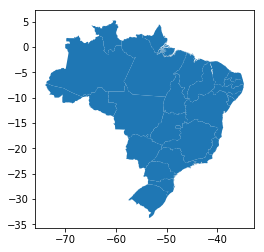

In [3]:
geodf.plot()

Vamos rapidamente tratar o arquivo csv que geramos, removendo colunas desnecessárias e renomeando o que for necessário. 

In [5]:
def read_and_organize():
    df = pd.read_csv('../DfUnic.csv')
    df = df.drop(columns={df.columns[0]})
    df = df.drop(columns="cod ibge")
    # Colocando o nome como COD_UF para ficar ao de geodf no merge. 
    df = df.rename(index=str, columns={"cod uf": "COD_UF"}) 
    return df

df = read_and_organize()
df.head()

,ano,região,COD_UF,uf,município,sexo,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,2008,CENTRO-OESTE,53.0,DF,BRASILIA,F,0.0,0.0,1.0,0.0,1.0
1,2008,CENTRO-OESTE,52.0,GO,ABADIA DE GOIAS,F,0.0,0.0,0.0,0.0,0.0
2,2008,CENTRO-OESTE,52.0,GO,ABADIANIA,F,0.0,1.0,9.0,1.0,11.0
3,2008,CENTRO-OESTE,52.0,GO,ACREUNA,F,0.0,0.0,12.0,1.0,13.0
4,2008,CENTRO-OESTE,52.0,GO,ADELANDIA,F,0.0,0.0,1.0,1.0,2.0


Agruparemos, então, as informações por Estado. 

In [6]:
# Juntando as informações de todas as cidades por estado, de ambos os sexos. 
states_df = df.groupby(['COD_UF', 'ano'], as_index=False).sum()
states_df.head()

,COD_UF,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,11.0,2008,17.0,43.0,2259.0,243.0,2562.0
1,11.0,2009,20.0,66.0,2694.0,367.0,3147.0
2,11.0,2010,45.0,93.0,3592.0,403.0,4133.0
3,11.0,2011,22.0,62.0,2012.0,215.0,2311.0
4,11.0,2012,37.0,94.0,3581.0,400.0,4112.0


#### Mesclando os dados ####

Temos, portanto, uma tabela com informações geográficas e uma tabela com informações nutricionais a respeito dos estados. Mas precisamos cruzar esses dados, mesclando as tabelas. Usamos o COD_UF, comum a ambas as tabelas, para o ponto de referência entre as tabelas.

In [7]:
# Fazendo o merge das informações do shapefile com o dataframe obtido pelo sisvan. 
# Assim, temos um dataframe contendo informações gerais do estado (todas as cidades)
# e de ambos os sexos, além da forma do estado, pois possui a coluna 'geometry' do shapefile
merged = geodf.merge(states_df, on='COD_UF')
merged.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,9.0,26.0,824.0,87.0,946.0
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17.0,34.0,1047.0,125.0,1223.0
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,24.0,66.0,1846.0,200.0,2136.0
3,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2011,19.0,38.0,1299.0,158.0,1514.0
4,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2012,21.0,46.0,1630.0,190.0,1887.0


Temos, então, informações geográficas e informações nutricionais em uma única tabela, como desejado. O próximo passo é obter os percentuais, caso seja desejado saber os dados em relação ao total.

In [66]:
def get_percentages(merged):
    merged['percent_muitobaixo'] = 100 * (merged['peso muito baixo'] / merged['total'])
    merged['percent_baixo'] = 100 * (merged['peso baixo'] / merged['total'])
    merged['percent_adequado'] = 100 * (merged['peso adequado'] / merged['total'])
    merged['percent_elevado'] = 100 * (merged['peso elevado'] / merged['total'])
    return merged

# Obtendo o percentual para o gráfico ficar mais fiel na representação da realidade
merged = get_percentages(merged)
merged.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total,percent_muitobaixo,percent_baixo,percent_adequado,percent_elevado
0,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2008,9.0,26.0,824.0,87.0,946.0,0.951374,2.748414,87.103594,9.196617
1,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2009,17.0,34.0,1047.0,125.0,1223.0,1.390025,2.780049,85.609158,10.220769
2,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2010,24.0,66.0,1846.0,200.0,2136.0,1.123596,3.089888,86.423221,9.363296
3,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2011,19.0,38.0,1299.0,158.0,1514.0,1.254954,2.509908,85.799207,10.435931
4,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2012,21.0,46.0,1630.0,190.0,1887.0,1.112878,2.437732,86.380498,10.068892


#### Escolhendo o ano e a variável desejada ####

Troque o valor na célula abaixo para escolher o ano em que deseja ver os dados dos mapas.

In [80]:
# ALTERE AQUI o ano em que você deseja ver os dados. Em seguida, execute novamente as células abaixo. 
year = 2018

In [81]:
# ALTERE AQUI para mudar o que será exibido pelo mapa! 
'''
Opções:
Percentual de ocorrência de peso muito baixo: percent_muitobaixo
Percentual de ocorrência de peso baixo: percent_baixo
Percentual de ocorrência de peso adequado: percent_adequado
Percentual de ocorrência de peso elevado: percent_elevado

Também é possível ver os números absolutos e o total por estado. 
'''
variable = 'percent_muitobaixo'

In [82]:
teste = merged.loc[merged['UF'] == 'DF']
teste.head()

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,peso muito baixo,peso baixo,peso adequado,peso elevado,total,percent_muitobaixo,percent_baixo,percent_adequado,percent_elevado
66,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2008,0.0,0.0,2.0,0.0,2.0,0.000000,0.000000,100.000000,0.000000
67,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2009,0.0,1.0,14.0,1.0,16.0,0.000000,6.250000,87.500000,6.250000
68,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2010,1.0,1.0,84.0,12.0,98.0,1.020408,1.020408,85.714286,12.244898
69,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2011,0.0,0.0,24.0,6.0,30.0,0.000000,0.000000,80.000000,20.000000
70,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2012,8.0,28.0,770.0,72.0,878.0,0.911162,3.189066,87.699317,8.200456


In [83]:
#Pegando informações apenas do ano desejado
merged_year = merged.loc[merged['ano'] == year]
merged_year.columns = ['ESTADOS', 'REGIAO', 'COD_UF', 'UF', 'geometry', 'ano', 'muitobaixo', 
                      'baixo', 'adequado', 'elevado', 'total', 'percent_muitobaixo', 'percent_baixo',
                      'percent_adequado', 'percent_elevado']
merged_year.head(7)

,ESTADOS,REGIAO,COD_UF,UF,geometry,ano,muitobaixo,baixo,adequado,elevado,total,percent_muitobaixo,percent_baixo,percent_adequado,percent_elevado
10,Acre,Norte,12.0,AC,POLYGON ((-73.8009788422554 -7.111452561913211...,2018,156.0,360.0,11385.000,964.0,10667.200,1.462427,3.374831,106.729039,9.037048
21,Alagoas,Nordeste,27.0,AL,(POLYGON ((-36.39119330741482 -10.500822065069...,2018,477.0,913.0,29745.136,4026.0,34916.381,1.366121,2.614819,85.189631,11.530405
32,Amapá,Norte,16.0,AP,(POLYGON ((-51.37380232136843 -0.3705300556351...,2018,81.0,194.0,4282.423,543.0,4850.673,1.669871,3.999445,88.285131,11.194323
43,Amazonas,Norte,13.0,AM,POLYGON ((-73.8009788422554 -7.111452561913211...,2018,928.0,2136.0,37406.630,4320.0,40229.196,2.306782,5.309577,92.983787,10.738470
54,Bahia,Nordeste,29.0,BA,(POLYGON ((-46.32975031667081 -13.252483567632...,2018,1805.0,4314.0,141775.769,16025.0,161025.666,1.120939,2.679076,88.045448,9.951830
65,Ceará,Nordeste,23.0,CE,(POLYGON ((-41.40013849957978 -3.3203860583824...,2018,920.0,2145.0,78289.316,13019.0,90726.966,1.014031,2.364236,86.291121,14.349648
76,Distrito Federal,Centro Oeste,53.0,DF,POLYGON ((-48.28666681849336 -15.8428175700448...,2018,50.0,186.0,5.540,295.0,6.071,823.587547,3063.745676,91.253500,4859.166529


#### Mapa coroplético ####
Baseado no ano e na informação escolhida. É exibido a partir do código abaixo. 

In [74]:
def get_vmin_and_vmax(variable):
    if(variable == 'percent_muitobaixo'):
        return merged_year.percent_muitobaixo.min(), merged_year.percent_muitobaixo.max()
    elif(variable == 'percent_baixo'):
        return merged_year.percent_baixo.min(), merged_year.percent_baixo.max()
    elif(variable == 'percent_adequado'):
        return merged_year.percent_adequado.min(), merged_year.percent_adequado.max()
    elif(variable == 'percent_elevado'):
        return merged_year.percent_elevado.min(), merged_year.percent_elevado.max()
    else:
        return 0,100

def choropleth_plots(variable, colors):
    merged_year.plot(column=variable, cmap=colors, linewidth=0.2, ax=ax, edgecolor='0.3')

    ax.axis('off')
    #ax.set_title('Peso muito baixo por estado (percentual)', fontdict={'fontsize': '16'})
    ax.annotate('Fonte: Relatórios do SISVAN (DATASUS)', xy=(0.1, .08), xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

    # Barra de cores
    vmin, vmax = get_vmin_and_vmax(variable)
    sm = mpl.cm.ScalarMappable(cmap=colors, norm=mpl.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm._A = []
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    ax

In [75]:
merged_year.percent_muitobaixo.max()

1.5037160799677363

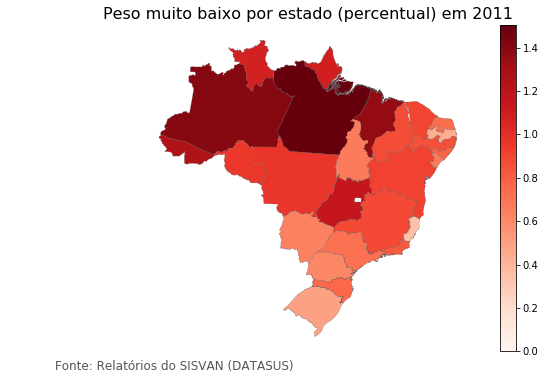

In [76]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso muito baixo por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_muitobaixo', colors="Reds")

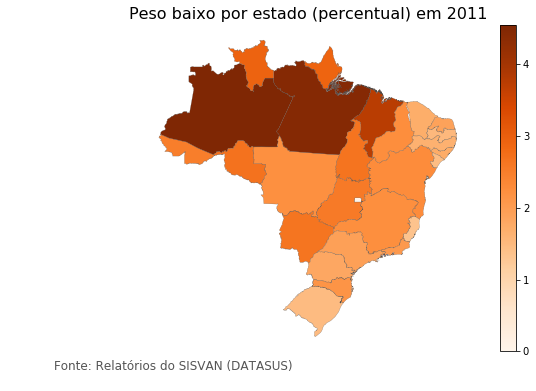

In [77]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso baixo por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_baixo', colors="Oranges")


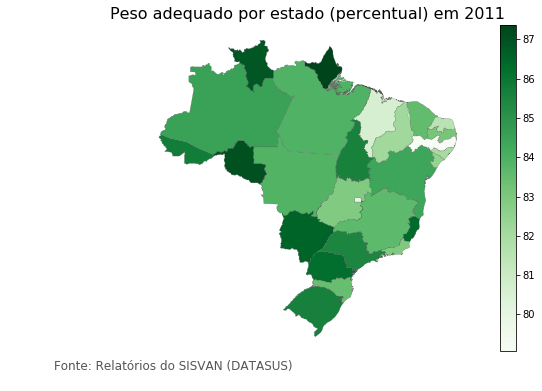

In [78]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso adequado por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_adequado', colors="Greens")

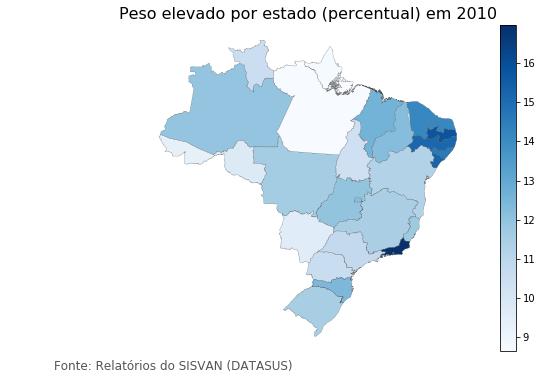

In [50]:
fig, ax = mpl.subplots(1, figsize=(10, 6))
ax.set_title('Peso elevado por estado (percentual) em '+str(year), fontdict={'fontsize': '16'})
choropleth_plots(variable = 'percent_elevado', colors="Blues")

#### Mapa interativo ####

Agora, criando o mapa interativo, baseado nas mesmas variáveis escolhidas para o mapa coroplético. 

Para o mapa interativo, usaremos a biblioteca Bokeh. Primeiramente, transformamos o nosso dado em um arquivo do tipo geojson, passo necessário para a utilização da biblioteca.

In [19]:
# Criando um geojson
geojson = merged_year.to_json()
with open("jsondata.geojson", "w") as f:
    f.write(geojson)

Importando os componentes necessários:

In [20]:
from bokeh.io import show, output_file, reset_output#, output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Viridis256
from bokeh.models import ColumnDataSource, OpenURL, TapTool

#output_notebook()

Então, graças aos passos executados anteriormente, o mapa já está pronto para ser plotado através do código abaixo.
O mapa abrirá em uma nova página html, e os estados podem ser clicados para obter mais informações a respeito de cada um dos estados.

In [21]:
reset_output()  # Linha necessária, pois o Bokeh possui uma persistência fazendo com que múltiplas
                # execuções do trecho abaixo fizesse com que o arquivo .html gerado fizesse vários
                # mapas, um abaixo do outro
output_file("interactiveplot.html", mode="inline")

with open(r'jsondata.geojson') as f:
    geo_src = GeoJSONDataSource(geojson=f.read())
        
cmap = LinearColorMapper(palette=Viridis256)

TOOLS = "tap,reset,hover,save"

br_map = figure(title='Estados do Brasil', tools=TOOLS, x_axis_location=None, y_axis_location=None, 
                width=500, height=500)
br_map.grid.grid_line_color = None

br_map.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'COD_UF', 'transform': cmap},
         line_color='black', line_width=0.5, source=geo_src)

hover = br_map.select_one(HoverTool)
hover.point_policy = 'follow_mouse'
hover.tooltips = [
    ('Estado', '@ESTADOS'), 
    ('Região', '@REGIAO')]

url = "plots/@COD_UF.html"
taptool = br_map.select(type=TapTool)
taptool.callback = OpenURL(url=url)

show(br_map)